# Equations and analytical solution

Solving the 1D WTG equation from our model :
Starting from 
$$\left\{\begin{array}{cccll} 
&-\omega_1 M_s &=& \frac{(q_1-T_1)_+}{\tau_c} &- \hat R \qquad(1)\\
 \mathbf{u_h} \cdot \nabla q_1&+\omega_1 M_q &=& -\frac{(q_1-T_1)_+}{\tau_c} &+ \hat E \qquad(2)
\end{array} \right.$$

Combine the two to get (where $M_h = M_s-M_q$) :
$$\mathbf{u_h} \cdot \nabla q_1 + \frac{M_h}{M_s}\frac{(q_1-T_1)_+}{\tau_c} + \frac{M_q}{M_s} \hat R - \hat E = 0$$

Assuming $CAPE =(q_1-T_1)_+ > 0$, 1D domain and defining :

$$\begin{array}{ccl}
\tau_c &=& \tau_{c0}f(x)\\
CAPE_{RCE} &=& \dfrac{\tau_{c0}}{M_h}(M_s \hat E - M_q \hat R) = \tau_{c0}\hat R = \tau_{c0}\hat E \qquad\text{(need } \hat R = \hat E \text{ for RCE to give } \omega_1=0)\\
CAPE &=& q_1-T_1\\
L &=& u_h \tau_{c0} \frac{M_s}{M_h}
\end{array}$$

We get : 
$$\begin{array}{ccl}
&\mathbf{u_h} \cdot \nabla q_1 + \frac{M_h}{M_s}\frac{(q_1-T_1)_+}{\tau_c} + \frac{M_q}{M_s} \hat R - \hat E &= 0\\
\Leftrightarrow& u_h \dfrac{\mathrm{d}CAPE}{\mathrm{d}x} + \dfrac{M_h}{M_s \tau_{c0}}\left(\dfrac{1}{f(x)} CAPE - CAPE_{RCE}\right) &=0\\
\Leftrightarrow& \dfrac{\mathrm{d}CAPE}{\mathrm{d}x} + \dfrac{1}{L}\left(\dfrac{1}{f(x)} CAPE - CAPE_{RCE}\right) &=0 \qquad(3)
\end{array}$$

Assuming $CAPE(x=0) = CAPE_{RCE}$, (3) solves into :

$$CAPE(x) = CAPE_{RCE} ~ e^{-\frac{1}{L}\int_0^x \mathrm{d}x_1/f(x_1)} \left( 1 + \displaystyle \frac{1}{L}\int_0^x e^{\frac{1}{L}\int_0^{x_1} \mathrm{d}x_2/f(x_2) } \mathrm{d}x_1 \right)$$

With $f(x)\equiv 1$, this reduces to $CAPE(x) = CAPE_{RCE}$ everywhere.


# Conservation property

If $f \equiv 1$ at infinity (ie $\exists x_0, \forall x>x_0 ~ f(x)=1$), then $\int_0^\infty \omega_1(x) \mathrm{d}x = 0$. If we crudely model precipitation as $Pr = -\dfrac{\omega_1}{g} q_{s0}$, with $q_{s0}$ some constant surface specific humidity, and allow for negative precipitation values, this means that **the mountain doesn't affect the total precipitation** ($\int_0^\infty Pr(x) \mathrm{d}x$ is always zero).

Indeed, from (1) and (3) $$\omega_1(x) = -\frac{1}{M_s \tau_{c0}} \left( \dfrac{CAPE(x)}{f(x)} - CAPE_{RCE}\right) = \frac{L}{M_s \tau_{c0}} \dfrac{\mathrm{d}CAPE}{\mathrm{d}x}$$

So $$\int_0^\infty \omega_1(x) \mathrm{d}x = \frac{L}{M_s \tau_{c0}} (CAPE(+\infty)-CAPE_{RCE}) = 0$$

Because from equation (3), if $f \equiv 1$ at infinity, $CAPE$ will converge exponentially to $CAPE_{RCE}$.

# Plotting CAPE and precipitation for different profiles of $f(x)$

In [1]:
from scipy.integrate import odeint,cumtrapz
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#define parameter values
Rhat = 1e-2 #in J/kg/s; corresponds to 100W/m^2 radiative cooling
tau_c0 = 1e4 # about 3 hours
M_s = 3.5e3 #in J/kg, from Neelin&Zeng. For our purposes, it should be in J/kg/Pa; but we only care about ratios so it's fine
M_q = 3e3 #in J/kg, from Neelin&Zeng
u_h = 5 # m/s
M_h = M_s-M_q

CAPERCE = tau_c0*Rhat
L = u_h*tau_c0*M_s/M_h

def precip(cape,M_s,tau_c,Rhat):
    """Compute a crude estimate of precipitation given some CAPE(x),tau_c(x) and input parameters : 
    precip = -omega_1/g * q0 with omega_1 from eqn (1) and q_0 = 10g/kg"""
    q0 = 1e-2
    g=10
    conversion = 86400
    return conversion*q0/g * (cape/tau_c-Rhat)/(M_s/(4*8e4)) #4*8e4 is the approximate integral of Omega_1(p)dp from Neelin&Zeng, to convert from their M_s to mine


In [3]:
print("L = %i km"%(L/1000))

L = 350 km


In [16]:
# define f, the spatial variation of tau_c. Ideally equal to 1 upstream and downstream of the mountain, with a dip in the middle
width = 500e3
mwidth = 50e3
strength=0.3
mcenter = 100e3
def domain():
    return np.linspace(0,width,100000)

def f_square(x):
    return 1 - (x>mcenter - mwidth/2)*(x<mcenter + mwidth/2)*strength

def f_gauss(x):
    m = mcenter
    sigma = mwidth/2
    return 1 - strength*np.exp(-(x-m)**2/(2*sigma**2))

500 km wide domain, 50 km wide mountain centered on x=100 km


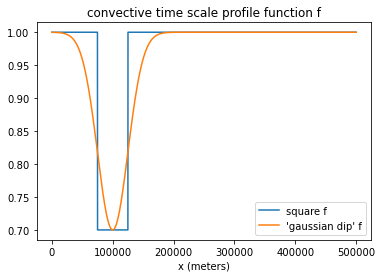

In [23]:
x = domain()
plt.plot(x,f_square(x),label="square f")
plt.plot(x,f_gauss(x),label="'gaussian dip' f")
plt.legend()
plt.xlabel("x (meters)")
plt.title("convective time scale profile function f")
print("%i km wide domain, %i km wide mountain centered on x=%i km"%(width/1000,mwidth/1000,mcenter/1000))

In [18]:
def ode(cape,x,f,L,CAPERCE):
    """function g such that equation (3) is dCape/dx = g(x)"""
    return -1/L * (cape/f(x) - CAPERCE)

def analyticalsol(x,f,L,CAPERCE):
    """Analytical solution to equation (3)"""
    c = cumtrapz(1/f(x),x,initial=0)
    return CAPERCE * np.exp(-c/L) * (1+cumtrapz(np.exp(c/L),x,initial=0)/L)

def solve(f,L,CAPERCE,M_s,tau_c0,Rhat):
    """Solve for the CAPE and precip given all problem parameters. 
    CAPE is solved both using the analytical solution and numerical integration; 
    turns out the ODE is pretty stiff so numerical intgration doesn't really work. """
    x = domain()
    cape  = odeint(ode,CAPERCE,x,args=(f,L,CAPERCE))[:,0]
    capea = analyticalsol(x,f,L,CAPERCE)
    pr = precip(capea,M_s,tau_c0*f(x),Rhat)
    return x,cape,capea,pr

In [19]:
x,CAPE_square,CAPE_squarea,pr_square = solve(f_square,L,CAPERCE,M_s,tau_c0,Rhat)
x,CAPE_gauss ,CAPE_gaussa ,pr_gauss = solve(f_gauss,L,CAPERCE,M_s,tau_c0,Rhat)

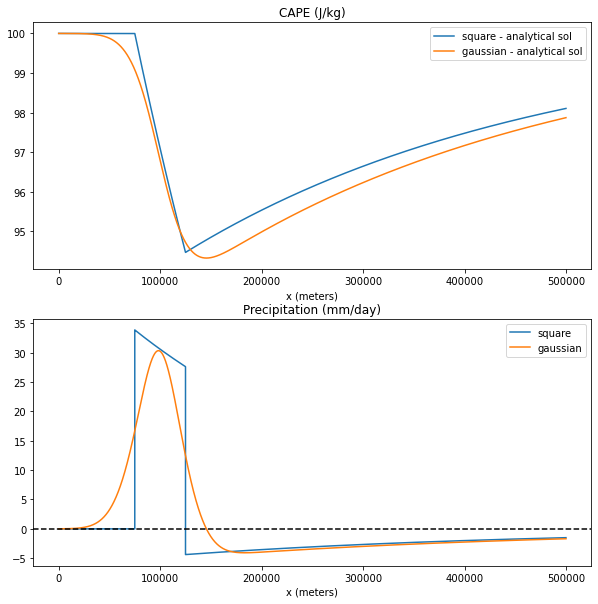

In [20]:
_,ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(x,CAPE_squarea, label="square - analytical sol")
ax[0].plot(x,CAPE_gaussa,label="gaussian - analytical sol")
ax[0].set_title("CAPE (J/kg)")

ax[1].plot(x,pr_square,label="square")
ax[1].plot(x,pr_gauss,label="gaussian")
#ax[1].plot(x,pr_test,label="test")
ax[1].set_title("Precipitation (mm/day)")
ax[1].axhline(0.,color='k', linestyle='--')

for a in ax:
    a.legend()
    a.set_xlabel("x (meters)")

#print("Integrated precip value, square : %.2f mm/day * m"%np.trapz(pr_square,x))
#print("Integrated precip value, gauss : %.2f mm/day * m"%np.trapz(pr_gauss,x))
#
#i= int((mcenter + mwidth/2) / width * 100000)
#print("Integrated precip value over mountain, square : %.2f mm/day * m"%np.trapz(pr_square[:i],x[:i]))
#print("Integrated precip value over mountain, gauss : %.2f mm/day * m"%np.trapz(pr_gauss[:i],x[:i]))
#
#print("PCT, square : %.2f %%"%(100*np.trapz(pr_square,x)/np.trapz(pr_square[:i],x[:i])))
#print("PCT, gauss : %.2f %%"%(100*np.trapz(pr_gauss,x)/np.trapz(pr_gauss[:i],x[:i])))

Main comments (Quentin) : Please note that negative precips stem from downward motion (positive $\omega_1$ downstream of the mountain). I would add this to a background RCE precip value of e.g. 5mm/day to get a physical result. I left that to show the extent of the downstream rain shadow.

The orders of magnitude sound fine. For $f(x)$, I basically chose a profile that drops below 1 on the mountain length scale, (i.e. a 50km wide mountain here); and I tuned the strength of the drop (in that case, it drops from 1 to 0.7) in order to have sound precip values.

The rain shadow basically extends on a length scale $L$ (CAPE e-folding length), 350km in this case. This, as well as the strength of the rain shadow, seems pretty physical. I still have to compare that to the simulation results / real world profiles.